# LSTM2

In [245]:
# 모듈로딩
from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## [ 학습 함수 ]
---

In [246]:
# [ 학습 함수 ]
# ex: data = [1,2,3,4,5,6,7,8,9,10]가 주어졌을 때 generateX(data, 5)를 실행하면
# 아래와 같은 학습데이터 변환한다.
#
# x                      y
# ---------              -
# 1,2,3,4,5              6
# 2,3,4,5,6              7
# 3,4,5,6,7              8
# ...

# a= data, n = 학습할 과거 데이터 수
# --> 예측값 개수 : 전체 데이터 갯수 - n (앞쪽데이터 n개가 제외됨)
def generateX(a, n): # a=data, n=5
    x_train = []
    y_train = []
    for i in range(len(a)): # i = 0~9 
        x = a[i:(i + n)] # x : 0~4,1~5,2~6,3~7,4~8,5~9...9~14
        if (i + n) < len(a): # target data가 있는 범위까지만
            x_train.append(x) # x_train = 0~4,1~5,2~6,3~7,4~8까지
            y_train.append(a[i + n]) # y_train = 5,6,7,8,9
        else:
            break
    return np.array(x_train), np.array(y_train)
    # x_train 개수: date개수 - n(뒤)
    # y_train 개수: date개수 - n(앞)

### 테스트 방법
---
1. data : 데이터 총 개수 조정 
2. n : 과거학습단위 조정
3. x.reshape[1] = 과거학습단위
4. train_size : test_size를 고려하여 조정
5. run

- 테스트 사이즈 조건: test size >= 2*(과거 학습 단위) 
    - test size = len(data) - train_size


In [258]:
def pred_future(data,past_learn):

    train_size = len(data)-(2*past_learn)
    test_size = len(data)- train_size
    
    print(f'예측 개월 수: {past_learn}개월')
    print('--------------------------------')

    # [ 조건 ]
    if test_size < 2*past_learn:
        print(f'past_learn을 {len(data)/2} 이하로 입력해주세요')



    # [ 과거데이터 학습 단위 설정]
    x, y = generateX(data, past_learn) 

    print('[ before reshape ]')
    print('x.shape:',x.shape)
    print('y.shape:',y.shape)

    # 차원 하나씩 추가
    x = x.reshape(-1,past_learn,1)
    y = y.reshape(-1,1)

    print('[ after reshape ]')
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)



    # [ 학습 사이즈 ] -> train, test 
    # train_size = len(data)-(2*past_learn)

    # 학습용 데이터와 시험용 데이터
    x_train = x[:train_size, :, :]
    y_train = y[:train_size, :]
    x_test = x[train_size:, :, :]
    y_test = y[train_size:, :]

    print('x_train.shape:', x_train.shape,'y_train.shape:', y_train.shape)
    print('x_test.shape :', x_test.shape, 'y_test.shape :', y_test.shape)



    # # [ LSTM model ]
    # # 2층-양방항 구조의 LSTM 모델을 생성한다.
    # K.clear_session()     # 모델 생성전에 tensorflow의 graph 영역을 clear한다.
    # xInput = Input(batch_shape=(None, x_train.shape[1], x_train.shape[2]))
    # xLstm_1 = LSTM(10, return_sequences = True)(xInput)
    # xLstm_2 = Bidirectional(LSTM(10))(xLstm_1)
    # xOutput = Dense(1)(xLstm_2)

    # model = Model(xInput, xOutput)
    # model.compile(loss='mse', optimizer='adam')

    # # 학습
    # model.fit(x_train, y_train, epochs=50, batch_size=20,verbose=1)

    # # 예측
    # y_hat = model.predict(x_test, batch_size=1)
    

    model = Sequential()
    model.add(LSTM(16, 
                input_shape=(x_train.shape[1], x_train.shape[2]), 
                activation='relu', 
                return_sequences=False)
            )

    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=10)

    history = model.fit(x_train, y_train, 
                                    epochs=1000, 
                                    batch_size=16)
                                    # callbacks=[early_stop])
    
    y_hat = model.predict(x_test)


    # [ 예측 결과 시각화 ]
    a_axis = np.arange(0, len(y_train))
    b_axis = np.arange(len(y_train), len(y_train) + len(y_hat))

    plt.figure(figsize=(16,9)) 
    plt.plot(a_axis, y_train.reshape(x_train.shape[0],), 'o-') 
    plt.plot(b_axis, y_hat.reshape(x_test.shape[0],), 'o-', color='red', label='Predicted')
    plt.plot(b_axis, y_test.reshape(x_test.shape[0],), 'o-', color='green', alpha=0.2, label='Actual')
    plt.legend()
    plt.show()

    return y_hat

예측 개월 수: 24개월
--------------------------------
[ before reshape ]
x.shape: (276, 24)
y.shape: (276,)
[ after reshape ]
x.shape: (276, 24, 1)
y.shape: (276, 1)
x_train.shape: (252, 24, 1) y_train.shape: (252, 1)
x_test.shape : (24, 24, 1) y_test.shape : (24, 1)
Epoch 1/1000
16/16 [==============================] - 2s 5ms/step - loss: 0.7352
Epoch 2/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.5778
Epoch 3/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.4624
Epoch 4/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.3597
Epoch 5/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.2250
Epoch 6/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.1396
Epoch 7/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.1204
Epoch 8/1000
16/16 [==============================] - 0s 6ms/step - loss: 0.1095
Epoch 9/1000
16/16 [==============================] - 0s 5ms/step - loss: 0.1123
Epoch 10/1

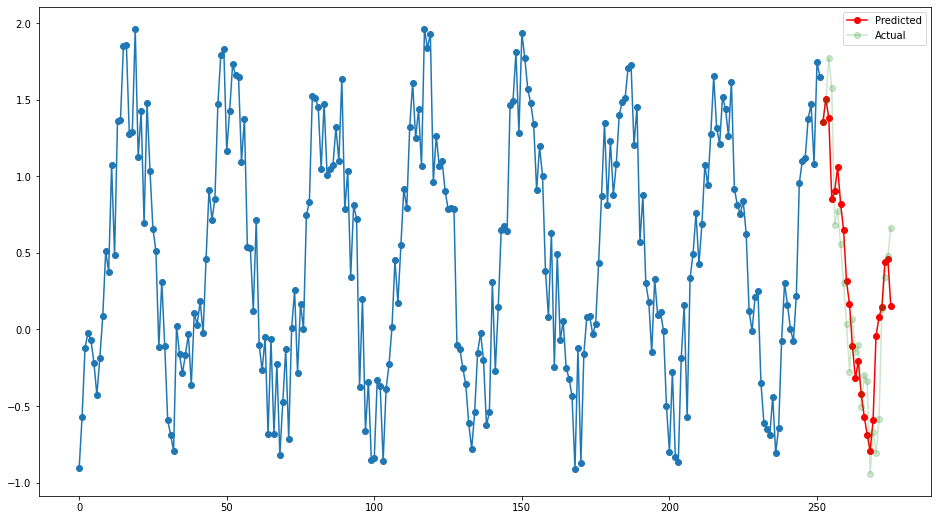

In [248]:
# [ 조정 변수]

# 총 데이터
data = np.sin(2 * np.pi * 0.03 * np.arange(0, 300)) + np.random.random(300) # Sine 함수에 노이즈를 섞은 데이터로 학습 데이터 100개를 생성한다

# 과거 학습 단위 = 예측하게 되는 타겟 갯수
past_learn = 24

# past_learn: 과거 학습할 데이터 단위 
y_hat = pred_future(data,past_learn)

# bigstar
--- 

In [249]:
# 데이터 로딩
data = pd.read_csv('./data_m.csv')
target = pd.read_csv('./target.csv')

data_all = pd.concat([data,target[['CIVIL','IND']]], axis=1)

In [250]:
data_all['CIVIL']

0       605519
1       566323
2       477514
3       337797
4       184522
        ...   
295     398661
296     380235
297     616682
298    1093747
299    1921404
Name: CIVIL, Length: 300, dtype: int64

예측 개월 수: 24개월
--------------------------------
[ before reshape ]
x.shape: (276, 24)
y.shape: (276,)
[ after reshape ]
x.shape: (276, 24, 1)
y.shape: (276, 1)
x_train.shape: (252, 24, 1) y_train.shape: (252, 1)
x_test.shape : (24, 24, 1) y_test.shape : (24, 1)
Epoch 1/1000
16/16 [==============================] - 2s 6ms/step - loss: 1197746290688.0000
Epoch 2/1000
16/16 [==============================] - 0s 6ms/step - loss: 1079722770432.0000
Epoch 3/1000
16/16 [==============================] - 0s 8ms/step - loss: 738378055680.0000
Epoch 4/1000
16/16 [==============================] - 0s 7ms/step - loss: 657452236800.0000
Epoch 5/1000
16/16 [==============================] - 0s 6ms/step - loss: 491995856896.0000
Epoch 6/1000
16/16 [==============================] - 0s 6ms/step - loss: 363659591680.0000
Epoch 7/1000
16/16 [==============================] - 0s 6ms/step - loss: 441554599936.0000
Epoch 8/1000
16/16 [==============================] - 0s 7ms/step - loss: 326713114624.0000
E

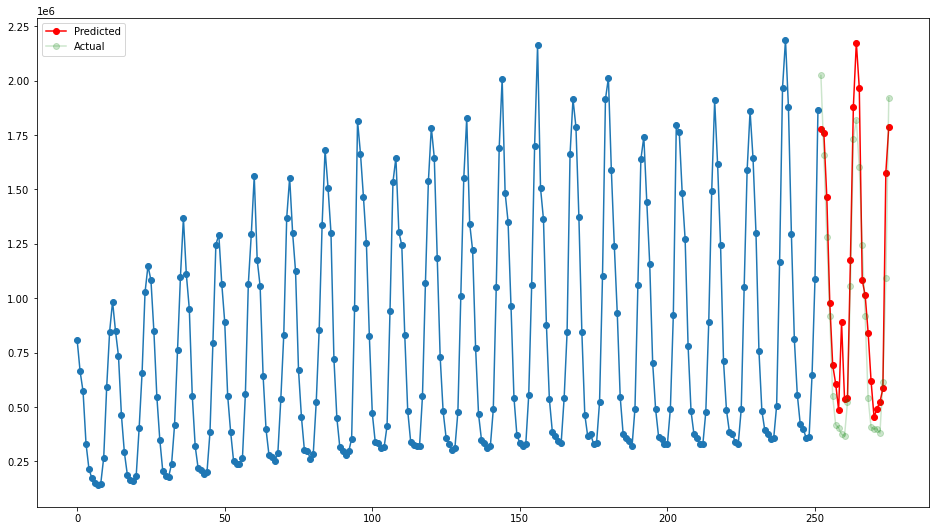

In [251]:
data = data_all['CIVIL']
past_learn = 24

y_hat = pred_future(data,past_learn)

In [252]:
y_hat 

array([[1777066.2 ],
       [1759044.1 ],
       [1463410.9 ],
       [ 979996.94],
       [ 691480.5 ],
       [ 607483.94],
       [ 486272.  ],
       [ 888572.1 ],
       [ 537698.8 ],
       [ 540474.44],
       [1173831.8 ],
       [1880576.1 ],
       [2174564.8 ],
       [1966481.  ],
       [1083337.8 ],
       [1012601.94],
       [ 841690.25],
       [ 618470.5 ],
       [ 453583.97],
       [ 492964.03],
       [ 522927.56],
       [ 585355.9 ],
       [1577231.  ],
       [1787285.8 ]], dtype=float32)

In [253]:
data[-24:]

276    2023662
277    1660132
278    1279302
279     920035
280     548871
281     419341
282     403664
283     374639
284     366621
285     520739
286    1055013
287    1732147
288    1819123
289    1604680
290    1243141
291     918206
292     539517
293     406010
294     399937
295     398661
296     380235
297     616682
298    1093747
299    1921404
Name: CIVIL, dtype: int64